Training on device cuda.
Exp tensor shape: torch.Size([476, 4692])
Exp num_features 4692
num_ccl,num_drug:  476 1440
id_unrepeat_train (380,)
id_unrepeat_val (48,)
id_unrepeat_test (48,)
id_unrepeat_train_val (428,)
id_test.shape (69120,)


STAGE:2025-02-26 09:45:39 951193:951193 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


FOLD 0
--------------------------------------------------------------
(342,) (86,)
id_train.shape (492480,)
id_val.shape (123840,)
State_dict for Sequential(
  (0): Linear(in_features=4692, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ScaledSigmoid(scale=8)
  (4): Linear(in_features=100, out_features=50, bias=True)
) loaded successfully.

 Drug_SelfAttention is applied 

best Epoch :  1 best_val_loss :  4.5068145 best_val_epoch_train_loss :  3.979519  batch_size :  100 learning_rate :  1e-05  warmup_iters : 60  with Decrease_percent :  0.9


STAGE:2025-02-26 09:46:00 951193:951193 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-02-26 09:46:01 951193:951193 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         model_training        36.90%        6.968s        99.29%       18.751s       18.751s       0.000us         0.00%        1.860s        1.860s             1  
                                            aten::addmm         4.64%     875.721ms         7.51%        1.418s      76.247us     505.244ms        29.86%     531.482ms      28.574us         18600  
         

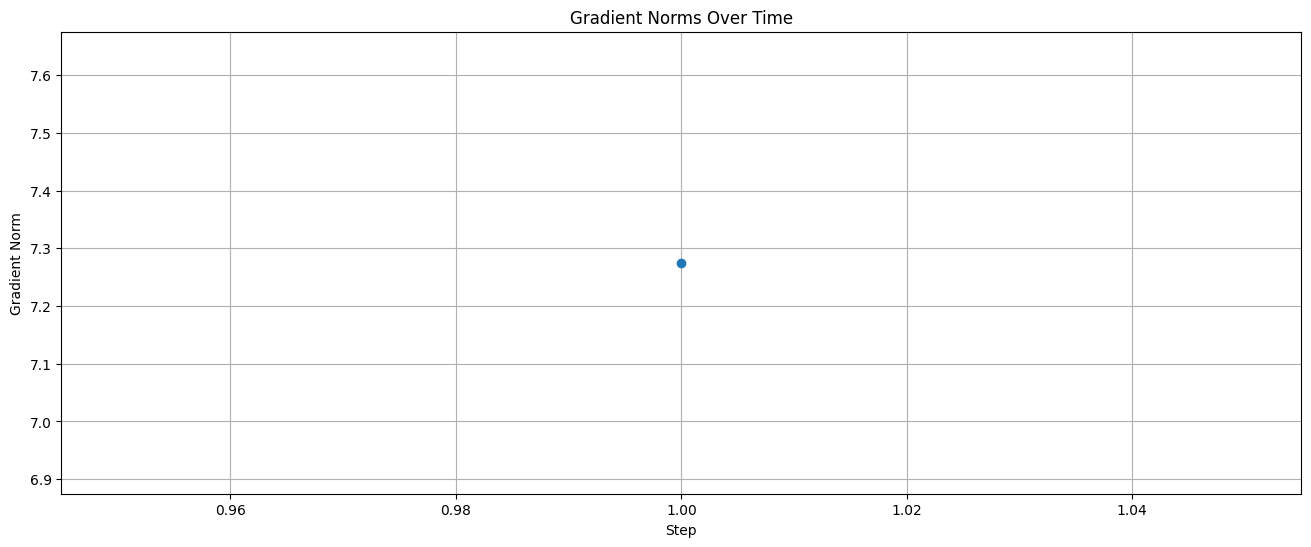

In [1]:
#main_kfold

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util
from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage
from utils.Metrics import MetricsCalculator


# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction
from utils.Custom_Activation_Function import ScaledSigmoid

test = False #False, True: batch_size = 3, num_epoch = 2, full dataset

omics_files = {
    'Mut': "../data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt",
    'Exp': "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[1000,100,50],'Exp':[1000,100,50], # Dr.Chiu:exp[500,200,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  'Exp': "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DrugESPF_Model"
AUCtransform = "-log2" #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 5
include_omics = ['Exp']
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!!
drug_embedding_feature_size = 128
ESPF = True # False True
Drug_SelfAttention = True 
#需再修改-----------

intermediate_size =512
num_attention_heads = 8
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    
    drug_encode_dims =[1600,400,100] # 50*128
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
#需再修改-------------
    
activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = ScaledSigmoid(scale=8) # GroundT range ( 0 ~ scale )
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 100
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 60
Decrease_percent = 0.9
continuous = True
learning_rate=1e-05
criterion = Custom_Weighted_LossFunction(loss_type="weighted_MSE", loss_lambda=1.0, regular_type="L2", regular_lambda=1e-05) #nn.MSELoss()#
""" A customizable loss function class.
    Args:
        loss_type (str): The type of loss to use ("RMSE", "MSE", "MAE", "MAE+MSE", "MAE+RMSE")/("weighted_RMSE", "weighted_MSE", "weighted_MAE", "weighted_MAE+MSE", "weighted_MAE+RMSE").
        loss_lambda (float): The lambda weight for the additional loss (MSE or RMSE) if applicable. Default is MAE+ 1.0*(MSE or RMSE).
        regular_type (str): The type of regularization to use ("L1", "L2", "L1+L2"), or None for no regularization.
        regular_lambda (float): The lambda weight for regularization. Default is 1e-05."""

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_Tranformer{Drug_SelfAttention}').translate(__translation_table__)









device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

#--------------------------------------------------------------------------------------------------------------------------

set_seed(seed)
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)

    if test is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed
    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

#----------------------------------------------------------------------------------------------------------------------
#load data
# data_mut, gene_names_mut,ccl_names_mut  = load_ccl("/root/data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt")
drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# data_AUC_matrix, drug_names_AUC, ccl_names_AUC = load_AUC_matrix(splitType,"/root/Winnie/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted.csv") # splitType = "byCCL" or "byDrug" 決定AUCmatrix要不要轉置

# matched AUCfile and omics_data samples
matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))

AUC_df= (AUC_df.T[matched_samples]).T
if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
    
if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
    kfoldCV = 2
    print("kfoldCV",kfoldCV)

if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    few_samples = (AUC_df.values > weighted_threshold).sum().item()
    more_samples = total_samples - few_samples
    few_weight = total_samples / (2 * few_samples)  
    more_weight = total_samples / (2 * more_samples)   
    # print("weighted_threshold",weighted_threshold)
    # print("total_samples",total_samples)
    # print("few_samples",few_samples)
    # print("more_samples",more_samples)
    # print("few_weight",few_weight)
    # print("more_weight",more_weight)
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None

#--------------------------------------------------------------------------------------------------------------------------
# 檢查有無重複的SMILES
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]

    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    # drug_encode = pd.Series(drug_smiles.unique()).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))# 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    # uniq_smile_dict = dict(zip(drug_smiles.unique(),drug_encode))# zip drug_smiles和其subword vector編碼 成字典

    # print(type(smile_encode))
    # print(smile_encode.shape)
    # print(type(smile_encode.index))
    # print((drug_encode.index.values).shape)#(42,)
    # print((drug_encode).shape)#(42,)
    # print(type(drug_encode))#<class 'pandas.core.series.Series'>
    #print((drug_encode.values).shape)#(42,)
    # print(drug_encode.values.tolist())
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

#--------------------------------------------------------------------------------------------------------------------------
# Convert your data to tensors if they're in numpy
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32)

#--------------------------------------------------------------------------------------------------------------------------
# randomly split
# 90% for training(10% for validation) and 10% for testing
id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
# repeat the test id
if splitType == "byCCL":
    repeatNum = num_drug
elif splitType == "byDrug":
    repeatNum = num_ccl
id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')   


#create dataset
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

test_dataset = Subset(dataset, id_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
#--------------------------------------------------------------------------------------------------------------------------
# k-fold run
kfold_losses= {}
best_fold_train_epoch_loss_list = []#  for train every epoch loss plot (best_fold)
best_fold_val_epoch_loss_list = []#  for validation every epoch loss plot (best_fold)
best_test_loss = float('inf')
best_fold_best_weight=None
set_seed(seed)


from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_training"):

        kfold = KFold(n_splits=kfoldCV, shuffle=True, random_state=seed) #shuffle the order of split subset
        for fold, (id_unrepeat_train, id_unrepeat_val) in enumerate(kfold.split(id_unrepeat_train_val)):
            print(f'FOLD {fold}')
            print('--------------------------------------------------------------')
            print(id_unrepeat_train.shape,id_unrepeat_val.shape)
            # correct the id 
            id_unrepeat_train = np.array(id_unrepeat_train_val)[id_unrepeat_train.tolist()]
            id_unrepeat_val = np.array(id_unrepeat_train_val)[id_unrepeat_val.tolist()]
            # repeat the id 
            id_train = repeat_func(id_unrepeat_train, repeatNum, setname='train')
            id_val = repeat_func(id_unrepeat_val, repeatNum, setname='val')

            set_seed(seed)
            train_dataset = Subset(dataset, id_train.tolist())# create dataset
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
            val_dataset = Subset(dataset, id_val.tolist())
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

            # train
            # Init the neural network 
            set_seed(seed)
            model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention,
                                    drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                                    TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
            model.to(device=device)

            optimizer = optim.Adam(model.parameters(), lr=learning_rate)# Initialize optimizer


            best_epoch, best_weight, best_val_loss, train_epoch_loss_list, val_epoch_loss_list,best_val_epoch_train_loss,best_epoch_attention_score_matrix , gradient_fig,gradient_norms_list = train( model,
                optimizer,      batch_size,      num_epoch,      patience,      warmup_iters,      Decrease_percent,    continuous,
                learning_rate,      criterion,      train_loader,      val_loader,
                device,ESPF,Drug_SelfAttention, seed, kfoldCV ,weighted_threshold, few_weight, more_weight)

            print("best Epoch : ",best_epoch,"best_val_loss : ",best_val_loss,"best_val_epoch_train_loss : ",best_val_epoch_train_loss," batch_size : ",batch_size,
                    "learning_rate : ",learning_rate," warmup_iters :" ,warmup_iters  ," with Decrease_percent : ",Decrease_percent )

            break
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))